# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.utils.constants import L_v, c_p, g
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_lambda_2_theory
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
from scipy.stats import median_abs_deviation
import uncertainties
import matplotlib.transforms as mtransforms
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
from isca_tools.utils.radiation import frierson_atmospheric_heating
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [108]:
# Load dataset
var_keep = ['temp', 'sphum', 'height', 'convflag', 'klzbs']
# var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'aquaplanet/vary_depth/depth=1/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:14<00:00,  1.82s/it]


## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [109]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [110]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    season_months = {'nh': [12, 1, 2], 'sh': [6, 7, 8]}   # JJA for NH and DJF for SH

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 8/8 [01:28<00:00, 11.04s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [118]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
z_mean = np.zeros((n_exp, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting
with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.isel(pfull=ind_ft).mean(dim='lon_time')
        mse = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height)
        mse_mean[i] = mse.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3[i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, k, j] = ds_all[i].height.isel(pfull=ind_ft)[k, use_ind].mean()
                mse_quant3[i, :, k, j] = mse[:, k, use_ind].mean(dim='lon_time')
                temp_quant3[i, :, k, j] = ds_all[i].temp[:, k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

100%|██████████| 11088/11088 [01:38<00:00, 112.45it/s]


In [119]:
def get_gradient(temp_quant, temp_av, ref_ind, confidence = 0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence 
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_av, param), z_score * param_std

In [120]:
delta_mse_ratio = np.diff(mse_quant3[:, ind_surf], axis=0)/np.expand_dims(np.diff(mse_mean[:, ind_surf], axis=0), axis=-1)
# delta_temp_quant_theory[-1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_exp, n_lat, n_quant_all)) for method in
                           ['linear', 'const_rh', 'squared', 'squared_lambda', 'linear_full']}
for method in delta_temp_quant_theory:
    for i in range(n_lat):
        taylor_level_use = 'squared' if method[0] == 's' else 'linear_rh_diff'
        if method == 'linear_full':
            taylor_level_use = 'linear'
        delta_temp_quant_theory[method][:-1, i] = \
                get_delta_temp_quant_theory(temp_mean[:, ind_surf, i], sphum_mean[:, i], temp_quant3[:, ind_surf, i], 
                                            sphum_quant3[:, i], p_surface,
                                            const_rh=True if method=='const_rh' else False,
                                            delta_mse_ratio=delta_mse_ratio[:, i] if 'lambda' in method else None,
                                            taylor_level=taylor_level_use)

# theory3 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory3 = {method: temp_quant3.copy() for method in delta_temp_quant_theory}
for method in delta_temp_quant_theory:
    for j in range(n_exp-1):
        temp_quant_theory3[method][1+j] = temp_quant_theory3[method][j] + delta_temp_quant_theory[method][j]

In [121]:
confidence = 0.9        # desired confidence for shading in plots
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
sf_labels = ['All $\kappa$', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}

sf_av = temp_mean[:, ind_surf]

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                     sf_av[sf_tau_use[i], k], sf_tau_ref_ind,
                                                                                     confidence)
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory3[method][sf_tau_use[i], ind_surf, k, j],
                                                           sf_av[sf_tau_use[i], k],
                                                           sf_tau_ref_ind, confidence)[0]

## Simulated Scaling Factor
Combine simulations to plot the simulated warming of a given percentile as a function of the mean warming.

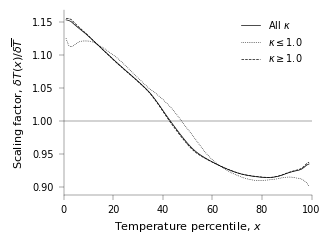

In [122]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='k', label=sf_labels[0])
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='k', linestyle=':',
        label = sf_labels[1])
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='k', linestyle='--',
        label = sf_labels[2])
ax.hlines(1, 0, 100, lw=ax_linewidth, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### Tropical Theory
Below I apply the theory developed for the tropics to the extratropics. It predicts the amplified warming of cold days, but is not quantitatively accurate.

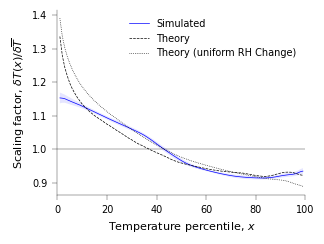

In [123]:
# Do a single plot combining all simulations
sf_ind_use = 0  # 0, 1 or 2
save_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quantiles_all, np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights), color='b', label='Simulated')
ax.plot(quantiles_all, np.average(scaling_factor_theory['linear'][sf_ind_use], axis=0, weights=lat_weights), color='k', 
        linestyle='--', label=f'Theory')
ax.plot(quantiles_all, np.average(scaling_factor_theory['const_rh'][sf_ind_use], axis=0, weights=lat_weights), color='k', linestyle=':', 
        label= f'Theory (uniform RH Change)')
# Add error
ax.fill_between(quantiles_all, np.average(scaling_factor[sf_ind_use]-scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), 
                np.average(scaling_factor[sf_ind_use]+scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), fc='b', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda$ Decomposition
The tropical theory assumes that $\lambda = \delta h(x)/\delta \overline{h} \approx 1$. Below, I split $\lambda$ into three variables linking free troposphere and surface to see why this is no longer the case in the extratropics.

The decomposition shows different things for hot and cold simulations.

In [124]:
lambda_1 = np.zeros((n_sf, n_lat, n_quant_all))
lambda_2 = np.zeros((n_sf, n_lat, n_quant_all))
lambda_3 = np.zeros((n_sf, n_lat))
lambda_full = np.zeros((n_sf, n_lat, n_quant_all))
labels = ['$\lambda(x) = \lambda_1(x) \lambda_2(x) / \overline{\lambda_1}$',
          '$\lambda_1(x)$',
          '$\lambda_2(x)$',
          '$\overline{\lambda_1}$']

with tqdm(total=n_sf*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for k in range(n_sf):
        sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[k]]==sf_tau_ref[k])[0]
        for i in range(n_lat):
            lambda_3[k, i] = get_gradient(mse_mean[sf_tau_use[k], ind_surf, i], 
                                          mse_mean[sf_tau_use[k], ind_ft, i], sf_tau_ref_ind)[0]
            for j in range(n_quant_all):
                lambda_1[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_surf, i, j], 
                                                 mse_quant3[sf_tau_use[k], ind_ft, i, j], sf_tau_ref_ind)[0]
                lambda_2[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_ft, i, j], 
                                                 mse_mean[sf_tau_use[k], ind_ft, i], sf_tau_ref_ind)[0]
                lambda_full[k, i, j] = get_gradient(mse_quant3[sf_tau_use[k], ind_surf, i, j], 
                                                    mse_mean[sf_tau_use[k], ind_surf, i], sf_tau_ref_ind)[0]
                pbar.update(1)

100%|██████████| 4158/4158 [00:02<00:00, 1976.31it/s]


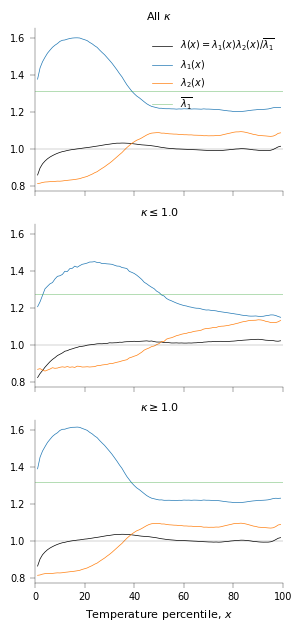

In [210]:
save_lambda_decomp_all_sf_fig = True
fig, ax = plt.subplots(n_sf,1, figsize=(width['one_col'], n_sf*width['one_col']/ar), sharex=True, sharey=True)
for k in range(n_sf):
    for i, var in enumerate([lambda_full, lambda_1, lambda_2]):
        use_color = 'k' if i == 0 else default_colors[i-1]
        ax[k].plot(quantiles_all, np.average(var[k], axis=0, weights=lat_weights),
                   color=use_color, label=labels[i])
    ax[k].axhline(np.average(lambda_3[k], axis=0, weights=lat_weights), color=default_colors[2], alpha=0.5, label=labels[3])
    ax[k].axhline(1, color='k', lw=ax_linewidth, alpha=0.5)
    ax[k].set_title(sf_labels[k])
ax[0].legend()
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel(percentile_label)
# ax.set_xlabel(f"{'Temperature percentile' if quant3_method=='temp' else 'Moist static energy percentile'}, $x$")
# ax.set_ylabel('Ratio of\nmoist static energy changes')
if save_fig or save_lambda_decomp_all_sf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_decomp_all_sf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### CAPE and $\epsilon=h(x)-h^*_{FT}(x)$
From above, we see that $\lambda_1 \neq 1$ implying that CAPE changes with warming. Below, I show that the CAPE has an almost 1:1 relationship with near-surface temperature. 
This increase in CAPE is not consistent with the assumption of CQE.

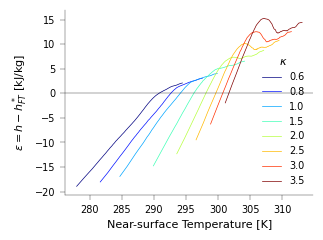

In [126]:
epsilon_quant3 = mse_quant3[:, 0] - mse_quant3[:, 1]

save_epsilon_fig = False
colors_exp = plt.cm.jet(np.linspace(0, 1, n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(epsilon_quant3[i], axis=0, weights=lat_weights), color=colors_exp[i], label=f'{tau_lw[i]}')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend(title='$\kappa$')
ax.set_ylabel('$\epsilon=h-h^*_{FT}$ [kJ/kg]')
ax.set_xlabel('Near-surface Temperature [K]')
if save_epsilon_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/epsilon_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### MSE as function of temperature
To delve more into the CAPE trend above, below I plot $h(x)$ (solid) and $h^*_{FT}(x)$ as a function of near-surface temperature. Both appear to show a 1:1 relationship and there doesn't seem to be anything stopping $h$ exceeding $h^*_{FT}$ as we may expect if convection was happening.

For each simulation, the line joins up all moist static energies evaluated at all 99 quantiles of near-surface temperature.

The black solid line on the left figure is $h$ with relative humidity of 0.7.

The black dotted line on the left figure is $h^*_{FT}$ evaluated at $T-30$ with $z_{500}=5500m$ i.e. with a constant lapse rate.

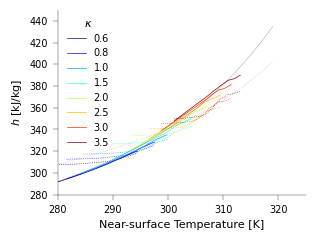

In [207]:
save_h_fig = False
# colors_exp = plt.cm.jet(np.linspace(0, 1, n_exp))
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    # if tau_lw[i]!=1 and tau_lw[i]!=1.5:
    #     continue
    ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights), color=colors_exp[i], 
               label=f'{tau_lw[i]}')
    ax.plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights), color=colors_exp[i], 
               linestyle=':')
temp_manual_plot = np.arange(250, 320)
ax.plot(temp_manual_plot, (c_p * temp_manual_plot + L_v * 0.7*sphum_sat(temp_manual_plot, p_surface))/1000, color='k', 
        lw=ax_linewidth, alpha=0.5)
ax.plot(temp_manual_plot, (c_p * (temp_manual_plot-30)+ L_v * sphum_sat(temp_manual_plot-30, pressure_ft_actual)+g*5500)/1000, color='k', 
        lw=ax_linewidth, alpha=0.5, linestyle=':')
ax.legend(title='$\kappa$')
ax.set_ylabel('$h$ [kJ/kg]')
ax.set_xlabel('Near-surface Temperature [K]')
# ax.set_xlim(253, 320)
# ax.set_xlim(290, 320)
# ax.set_ylim(300, 400)
ax.set_xlim(280, 325)
ax.set_ylim(280, 450)
if save_h_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/h_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Convflag as function of $x$ for each $\kappa$
We expect the amount of days convecting to increase with surface temperature. Below, we see that this assumption breaks down for the hottest simulations.

In [133]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

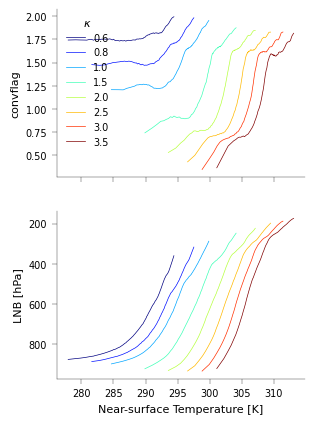

In [211]:
save_convflag_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             np.average(convflag_quant3[i], axis=0, weights=lat_weights), color=colors_exp[i], label=f'{tau_lw[i]}')
    ax[1].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights), 
             lzb(np.average(klzbs_quant3[i], axis=0, weights=lat_weights)), color=colors_exp[i])
ax[0].legend(title='$\kappa$')
ax[0].set_ylabel('convflag')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[1].invert_yaxis()
ax[1].set_ylabel('LNB [hPa]')
# ax.set_ylim(1, 2)
if save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

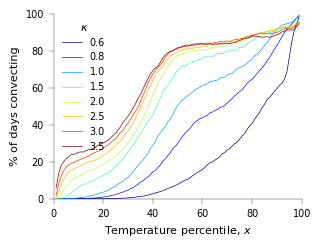

In [212]:
save_convfract_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(quantiles_all, 100*np.average(convfract_quant3[i], axis=0, weights=lat_weights), 
            color=colors_exp[i], label=f'{tau_lw[i]}')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel('% of days convecting')
ax.legend(title='$\kappa$')
if save_convfract_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convfract_{region}_{season}_kappa.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Sequential $\lambda$ Decomposition
The plots below emphasise that $\lambda_1/\overline{\lambda_1}$ decreases with $x$ for cold simulations but stays fairly constant except for the extremes for hot simulations.

I exclude the $\kappa=0.2$ simulation as it had some latitudes with negative $\lambda_1$.

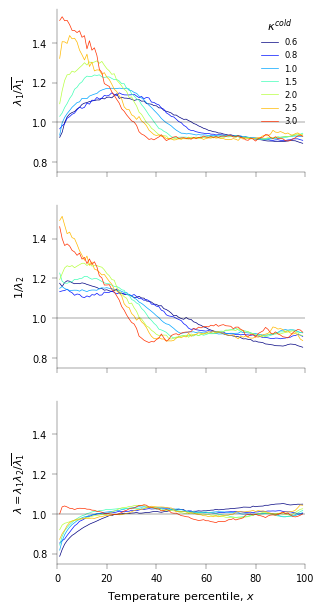

In [102]:
lambda_all_sim = np.zeros((n_exp-1, n_lat, n_quant_all))
lambda_1_all_sim = np.zeros((n_exp-1, n_lat, n_quant_all))
lambda_2_all_sim = np.zeros((n_exp-1, n_lat, n_quant_all))
lambda_3_all_sim = np.zeros((n_exp-1, n_lat))
for i in range(n_exp-1):
    lambda_all_sim[i] = (mse_quant3[i+1, ind_surf] - mse_quant3[i, ind_surf]
                              )/(mse_mean[i+1, ind_surf] - mse_mean[i, ind_surf])[:, np.newaxis]
    lambda_1_all_sim[i] = (mse_quant3[i+1, ind_surf] - mse_quant3[i, ind_surf]
                              )/(mse_quant3[i+1, ind_ft] - mse_quant3[i, ind_ft])
    lambda_2_all_sim[i] = (mse_quant3[i+1, ind_ft] - mse_quant3[i, ind_ft]) / (mse_mean[i+1, ind_ft] - mse_mean[i, ind_ft])[:, np.newaxis]
    lambda_3_all_sim[i] = (mse_mean[i+1, ind_surf] - mse_mean[i, ind_surf]) / (mse_mean[i+1, ind_ft] - mse_mean[i, ind_ft])

save_lambda_seq_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True, sharey=True)
for i in range(0, n_exp-1):
    ax[0].plot(quantiles_all, np.average(lambda_1_all_sim[i]/lambda_3_all_sim[i][:, np.newaxis], axis=0, weights=lat_weights), color=colors_exp[i], label=tau_lw[i])
    ax[1].plot(quantiles_all, 1/np.average(lambda_2_all_sim[i], axis=0, weights=lat_weights), color=colors_exp[i], label=tau_lw[i])
    ax[2].plot(quantiles_all, np.average(lambda_all_sim[i], axis=0, weights=lat_weights), color=colors_exp[i], label=tau_lw[i])
ax[0].legend(title='$\kappa^{cold}$', fontsize=6)
ax[0].set_ylabel('$\lambda_1/\overline{\lambda_1}$')
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[2].axhline(1, color='k', lw=ax_linewidth)
ax[1].set_ylabel('1/$\lambda_2$')
ax[2].set_ylabel('$\lambda = \lambda_1\lambda_2/\overline{\lambda_1}$')
ax[2].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)

if save_lambda_seq_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_seq_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## $\lambda_2$ Theory

Below, I investigate the $\lambda_2$ theory. In the top plot, I stagger the simulations by 0.4 for clarity. The thick lines show the simulated values. The solid lines show the full theory and the dotted lines show the theory excluding lapse rate changes and assuming $\delta z(x) = \delta \overline{z}$. Clearly this latter approximation gets a lot worse for the warmer simulations.

In the middle plot, I show the dynamical contribution from $\delta z(x)/\delta \overline{z}$ changes. In the bottom plot I show contribution from lapse rate changes: $\delta \kappa(x)$.

The $\delta \kappa(x)$ plot a looks a bit like the inverse of the $\lambda_1$ plot above. This sort of makes sense as both are about linking the surface and free troposphere on the $x^{th}$ percentile day. Whereas the $\delta z$ plot below is more about a horizontal link across the troposphere.

In [103]:
lambda_2_all_sim_theory = {'full': np.zeros((n_exp-1, n_lat, n_quant_all)), 'prefactor': np.zeros((n_exp-1, n_lat, n_quant_all)), 
                           'z': np.zeros((n_exp-1, n_lat, n_quant_all)), 'kappa': np.zeros((n_exp-1, n_lat, n_quant_all)), 
                           'zero_kappa': np.zeros((n_exp-1, n_lat, n_quant_all))}
for i in range(n_exp-1):
    lambda_2_use = get_lambda_2_theory(temp_quant3[i:i+2, ind_ft], temp_mean[i:i+2, ind_ft], z_quant3[i:i+2], z_mean[i:i+2], pressure_ft_actual)
    lambda_2_all_sim_theory['full'][i] = lambda_2_use[0]
    lambda_2_all_sim_theory['prefactor'][i] = lambda_2_use[1]['z2']
    lambda_2_all_sim_theory['z'][i] = lambda_2_use[1]['z1'] * lambda_2_use[1]['z2'] * lambda_2_use[2]['z_quant'] / lambda_2_use[2]['z_mean']
    lambda_2_all_sim_theory['kappa'][i] = lambda_2_use[1]['kappa'] * lambda_2_use[2]['kappa_quant'] / lambda_2_use[2]['z_mean']
    lambda_2_all_sim_theory['zero_kappa'][i] = lambda_2_use[1]['z2'] * lambda_2_use[2]['z_quant'] / lambda_2_use[2]['z_mean']

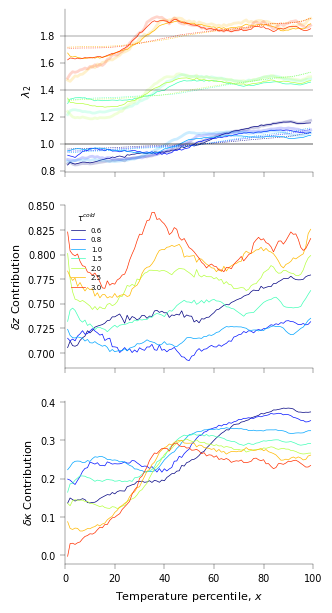

In [104]:
save_lambda2_seq_theory_fig = False
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True)
# Shift to make plots clearer
shift_factor = np.zeros(n_exp-1)
shift_factor[3:] = 0.4
shift_factor[5:] = 0.8
for i in range(0, n_exp-1):
    ax[0].plot(quantiles_all, np.average(lambda_2_all_sim[i], axis=0, weights=lat_weights)+shift_factor[i],
               color=colors_exp[i], lw=2, alpha=0.2)
    ax[0].plot(quantiles_all, np.average(lambda_2_all_sim_theory['full'][i], axis=0, weights=lat_weights)+shift_factor[i],
               color=colors_exp[i])
    ax[0].plot(quantiles_all, np.average(lambda_2_all_sim_theory['prefactor'][i], axis=0, weights=lat_weights)+shift_factor[i],
               color=colors_exp[i], linestyle=':')
    ax[1].plot(quantiles_all, np.average(lambda_2_all_sim_theory['z'][i], axis=0, weights=lat_weights), color=colors_exp[i], label=tau_lw[i])
    ax[2].plot(quantiles_all, np.average(lambda_2_all_sim_theory['kappa'][i], axis=0, weights=lat_weights), color=colors_exp[i])
ax[0].axhline(1, color='k', lw=ax_linewidth)
for var in np.unique(shift_factor):
    ax[0].axhline(1+var, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\lambda_2$')
ax[1].legend(title='$\\tau^{cold}$', fontsize=5, title_fontsize=6)
ax[1].set_ylabel('$\delta z$ Contribution')
ax[2].set_ylabel('$\delta \kappa$ Contribution')
ax[2].set_xlabel(percentile_label)
ax[0].set_xlim(0, 100)
if save_lambda2_seq_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda2_seq_theory_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### $\lambda$ Theory excluding $\delta \kappa$ term

Because the $\delta \kappa$ term looks like the inverse of $\lambda_1$, below I see if using the $\lambda_2$ theory assuming constant $\kappa$ is a good approximation for $\lambda$. 

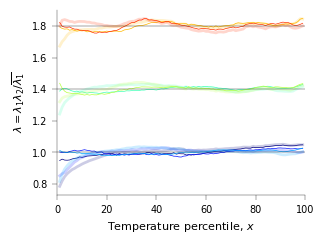

In [105]:
save_lambda_seq_theory_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
for i in range(0, n_exp-1):
    ax.plot(quantiles_all, np.average(lambda_all_sim[i], axis=0, weights=lat_weights)+shift_factor[i],
               color=colors_exp[i], lw=2, alpha=0.2)
    ax.plot(quantiles_all, np.average(lambda_2_all_sim_theory['zero_kappa'][i], axis=0, weights=lat_weights)+shift_factor[i],
               color=colors_exp[i])
for var in np.unique(shift_factor):
    ax.axhline(1+var, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylabel('$\lambda = \lambda_1\lambda_2/\overline{\lambda_1}$')
if save_lambda_seq_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_seq_theory_{region}_{season}.pdf",
                            dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Probability Density Function
#### Tropics
Below, I plot how the temperature distribution relative to the median changes with warming. Clearly, the coldest days become closer to the median as optical depth increases (blue $\rightarrow$ red). The hottest days also become closer to the median as optical depth increases for the lower optical depths. But for the hottest simulations, as the optical depth increases, the hottest days become hotter.
#### Extratropics
In the extratropics, the narrowing of the seasonal cycle (hottest days get cooler and coldest days get warmer relative to the median) with warming is much more apparent.

#### Standard Deviation
The third plot shows the standard deviation as a function of longwave optical depth, relative to the $\kappa=1$ simulation. This shows that the shape of the distribution stays more constant for MSE than temperature.

In [171]:
if region == 'extratropics':
    n_hist_bins = 33 * 3
    hist_bins_lims = [-33, 33]
elif region == 'tropics':
    n_hist_bins = 15 * 15
    hist_bins_lims = [-13, 13]
else:
    n_hist_bins = 49 * 3
    hist_bins_lims = [-49, 49]
temp_hist_counts = {'all': np.zeros((n_exp, n_lat, n_hist_bins)), 'conv': np.zeros((n_exp, n_lat, n_hist_bins)), 
                    'no-conv': np.zeros((n_exp, n_lat, n_hist_bins))}
temp_std_dev = {key: np.zeros((n_exp, n_lat)) for key in temp_hist_counts}
for i in range(n_exp):
    if 'convflag' in var_keep:
        is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
    ds_use = {'all': ds_all[i], 'conv': ds_all[i].where(is_convecting), 'no-conv': ds_all[i].where(np.invert(is_convecting))}
    for key in ds_use:
        for j in range(n_lat):
            temp_anomaly = ds_use[key].temp[ind_surf, j] - ds_use['all'].temp[ind_surf, j].mean()
            temp_hist_counts[key][i, j] = np.histogram(temp_anomaly, n_hist_bins, hist_bins_lims)[0]
            temp_std_dev[key][i, j] = ds_use[key].temp[ind_surf, j].std()
hist_bins = np.histogram(temp_anomaly, n_hist_bins, hist_bins_lims)[1]
hist_bin_centres = moving_average(hist_bins, 2)

temp_hist_weight = {key: np.average(temp_hist_counts[key], weights=lat_weights, axis=1) for key in temp_hist_counts}
temp_hist_weight = {key: temp_hist_weight[key] / np.sum(temp_hist_weight['all'], axis=1, keepdims=True) for key in temp_hist_counts}
# #Below is if I were to ignore latitude weighting
# temp_hist_weight2 = np.sum(temp_hist_counts, axis=1)
# temp_hist_weight2 = temp_hist_weight2/np.sum(temp_hist_weight2, axis=1, keepdims=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


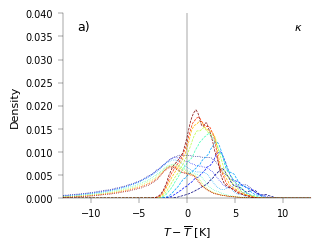

In [202]:
save_pdf_fig = True
plot_log = False
color_seq_exp = plt.cm.jet(np.linspace(0, 1, n_exp))
conv_linestyles = {'all': '-', 'conv': '--', 'no-conv': ':'}
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar))
for i in range(n_exp):
    for key in ['conv', 'no-conv']:
        ax.plot(hist_bin_centres, temp_hist_weight[key][i], color=color_seq_exp[i], 
                label=f'{tau_lw[i]}' if key == 'all' else None, linestyle=conv_linestyles[key])
ax.set_xlabel('$T-\overline{T}$ [K]')
ax.set_ylabel('Density')
if plot_log:
    ax.set_yscale('log')
    ax.set_ylim(10 ** -5, temp_hist_weight['all'].max())
else:
    ax.set_ylim(0, temp_hist_weight['all'].max())
ax.set_ylim(0, 0.04)
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], lw=ax_linewidth, colors='k')
ax.set_xlim(hist_bin_centres[0], hist_bin_centres[-1])
label_subplots(fig, ax)
if region == 'tropics':
    ax.legend(title='$\kappa$')
if save_fig or save_pdf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_pdf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [197]:
mse_hist_bins_lims = [-30, 30]
mse_hist_bins_lims = np.asarray(mse_hist_bins_lims) * 1000/c_p      # convert units from kJ/kg into Kelvin
mse_hist_counts = {key: np.zeros((n_exp, n_lat, n_hist_bins)) for key in temp_hist_counts}
mse_std_dev = {key: np.zeros((n_exp, n_lat)) for key in temp_hist_counts}
for i in range(n_exp):
    is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
    ds_use = {'all': ds_all[i], 'conv': ds_all[i].where(is_convecting), 'no-conv': ds_all[i].where(np.invert(is_convecting))}
    mse_mean = moist_static_energy(ds_use['all'].temp[ind_surf], ds_use['all'].sphum[ind_surf], ds_use['all'].height[ind_surf]
                                   ).mean(dim='lon_time')
    for key in ds_use:
        mse_use = moist_static_energy(ds_use[key].temp[ind_surf], ds_use[key].sphum[ind_surf], ds_use[key].height[ind_surf])
        for j in range(n_lat):
            mse_anomaly = mse_use[j]-mse_mean[j]
            mse_anomaly = 1000*mse_anomaly / c_p        # convert units from kJ/kg into Kelvin
            mse_hist_counts[key][i, j] = np.histogram(mse_anomaly, n_hist_bins, mse_hist_bins_lims)[0]
            mse_std_dev[key][i, j] = mse_use[j].std()
mse_hist_bin_centres = moving_average(np.histogram(mse_anomaly, n_hist_bins, mse_hist_bins_lims)[1], 2)

mse_hist_weight = {key: np.average(mse_hist_counts[key], weights=lat_weights, axis=1) for key in mse_hist_counts}
mse_hist_weight = {key: mse_hist_weight[key] / np.sum(mse_hist_weight['all'], axis=1, keepdims=True) for key in mse_hist_counts}
# mse_hist_weight = np.average(mse_hist_counts, weights=lat_weights, axis=1)
# mse_hist_weight = mse_hist_weight/np.sum(mse_hist_weight, axis=1, keepdims=True)

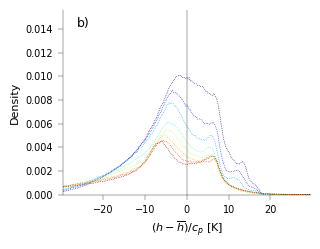

In [200]:
save_mse_pdf_fig = True
plot_log = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    for key in ['all']:
        ax.plot(mse_hist_bin_centres, mse_hist_weight[key][i], color=color_seq_exp[i], 
                label=f'{tau_lw[i]}' if key == 'all' else None, linestyle=conv_linestyles[key])
ax.set_xlabel('$(h-\overline{h})/c_p$ [K]')
ax.set_ylabel('Density')
if plot_log:
    ax.set_yscale('log')
    ax.set_ylim(10**-5, mse_hist_weight['all'].max())
else:
    ax.set_ylim(0, mse_hist_weight['all'].max())
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], lw=ax_linewidth, colors='k')
ax.set_xlim(mse_hist_bin_centres[0], mse_hist_bin_centres[-1])

# trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
# ax.text(0.0, 1.0, 'b)', transform=ax.transAxes + trans,
#         fontsize=9, verticalalignment='top', fontfamily='serif', font='Computer Modern',
#         bbox=dict(facecolor='1', edgecolor='none', pad=3.0))
label_subplots(fig, ax, ['b)'])

# if region == 'tropics':
#     ax.legend(title='$\kappa$')
if save_fig or save_mse_pdf_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_pdf_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

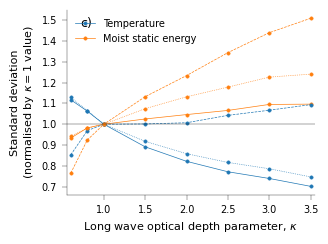

In [196]:
save_std_dev_fig = True
kappa1_ind = np.where(tau_lw==1)[0]
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for key in temp_std_dev:
    ax.plot(tau_lw, np.average(temp_std_dev[key]/temp_std_dev[key][kappa1_ind], axis=1, weights=lat_weights), 'o', 
            label='Temperature' if key=='all' else None, color=default_colors[0], linestyle=conv_linestyles[key])
    ax.plot(tau_lw, np.average(mse_std_dev[key]/mse_std_dev[key][kappa1_ind], axis=1, weights=lat_weights), 'o', 
            label='Moist static energy' if key=='all' else None, color=default_colors[1], linestyle=conv_linestyles[key])
ax.set_xlim(tau_lw[0]-0.05, tau_lw[-1]+0.05)
# ax.set_ylim(0.65, 1.2)
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], lw=ax_linewidth, colors='k')
label_subplots(fig, ax, ['c)'])
ax.legend()
ax.set_xlabel('Long wave optical depth parameter, $\kappa$')
ax.set_ylabel('$\sigma/\sigma_{\kappa=1}$')
ax.set_ylabel('Standard deviation\n(normalised by $\kappa=1$ value)')

if save_fig or save_std_dev_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/std_dev_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)